# This notebook compares 'P0030001' to the population 2020 data!

\#'Other columns of interest:

\#'Adj\_Pop',
'C\_TOT20',
'CVAP\_TOT20',
'proj21',
'proj22',
'proj23',
'proj24',
'proj25',
'proj26',
'proj27',
'proj28',
'proj29',
'proj30',
'P0030001'



In [2]:
import csv
import os
from functools import partial
import json
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,

    accept,
    constraints,
    updaters,
)
from gerrychain.constraints.contiguity import contiguous_components, contiguous
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [3]:
plot_df = gpd.read_file("../Data2020/BG_Merged.shp")

dual_graph = Graph.from_json("../Data2020/BG_Merged.json")


In [4]:
list(plot_df.columns)

['STATEFP20',
 'COUNTYFP20',
 'TRACTCE20',
 'BLKGRPCE20',
 'GEOID20',
 'NAMELSAD20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20',
 'FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOVAR',
 'GEOCOMP',
 'CHARITER',
 'LOGRECNO',
 'GEOID',
 'GEOCODE',
 'REGION',
 'DIVISION',
 'STATE',
 'STATENS',
 'COUNTY',
 'COUNTYCC',
 'COUNTYNS',
 'TRACT',
 'BLKGRP',
 'CBSA',
 'MEMI',
 'CSA',
 'METDIV',
 'AREALAND',
 'AREAWATR',
 'BASENAME',
 'NAME',
 'FUNCSTAT',
 'POP100',
 'HU100',
 'INTPTLAT',
 'INTPTLON',
 'LSADC',
 'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P0010014',
 'P0010015',
 'P0010016',
 'P0010017',
 'P0010018',
 'P0010019',
 'P0010020',
 'P0010021',
 'P0010022',
 'P0010023',
 'P0010024',
 'P0010025',
 'P0010026',
 'P0010027',
 'P0010028',
 'P0010029',
 'P0010030',
 'P0010031',
 'P0010032',
 'P0010033',
 'P0010034',
 'P0010035',
 'P0010036',
 '

In [5]:
num_districts = 10

updater = {
    "population": updaters.Tally("P0010001", alias="population"),
    "compare_pop": updaters.Tally('P0030001', alias="compare_pop"),
    "cut_edges": cut_edges,
}


In [6]:
totpop = 0

for n in dual_graph.nodes():
    try:
        totpop += dual_graph.nodes[n]["P0010001"]
    except KeyError as e:
        print(n)

ideal_pop = totpop/num_districts
    
cddict_trimmed =  recursive_tree_part(dual_graph,range(num_districts),ideal_pop,"P0010001", .02,1)

In [7]:
ideal_pop

770528.1

In [8]:
initial_enacted_part = Partition(dual_graph,"WACON",updater)

initial_chain_part = Partition(dual_graph,cddict_trimmed,updater)


In [9]:
print(len(cut_edges(initial_enacted_part)))
print(len(cut_edges(initial_chain_part)))


743
935


In [10]:
plot_df['C_x'] = plot_df.centroid.x
plot_df['C_y'] = plot_df.centroid.y

dual_graph.add_data(plot_df,columns=['C_x','C_y'])



/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as app


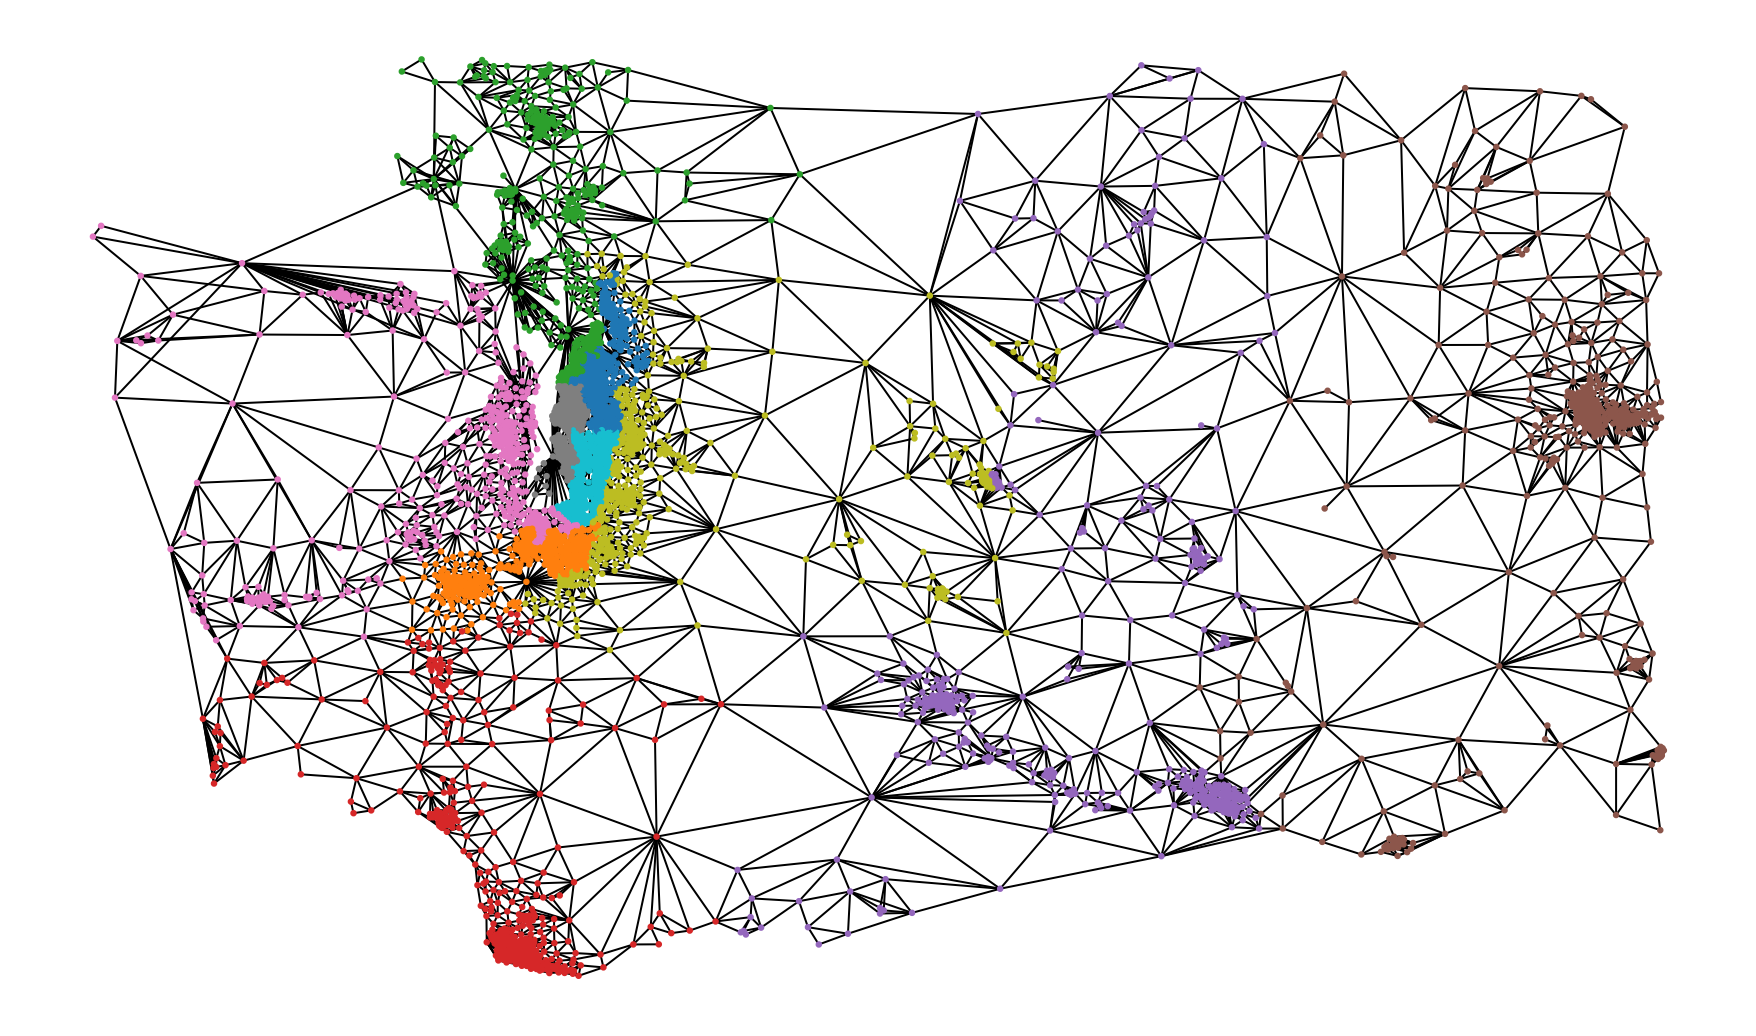

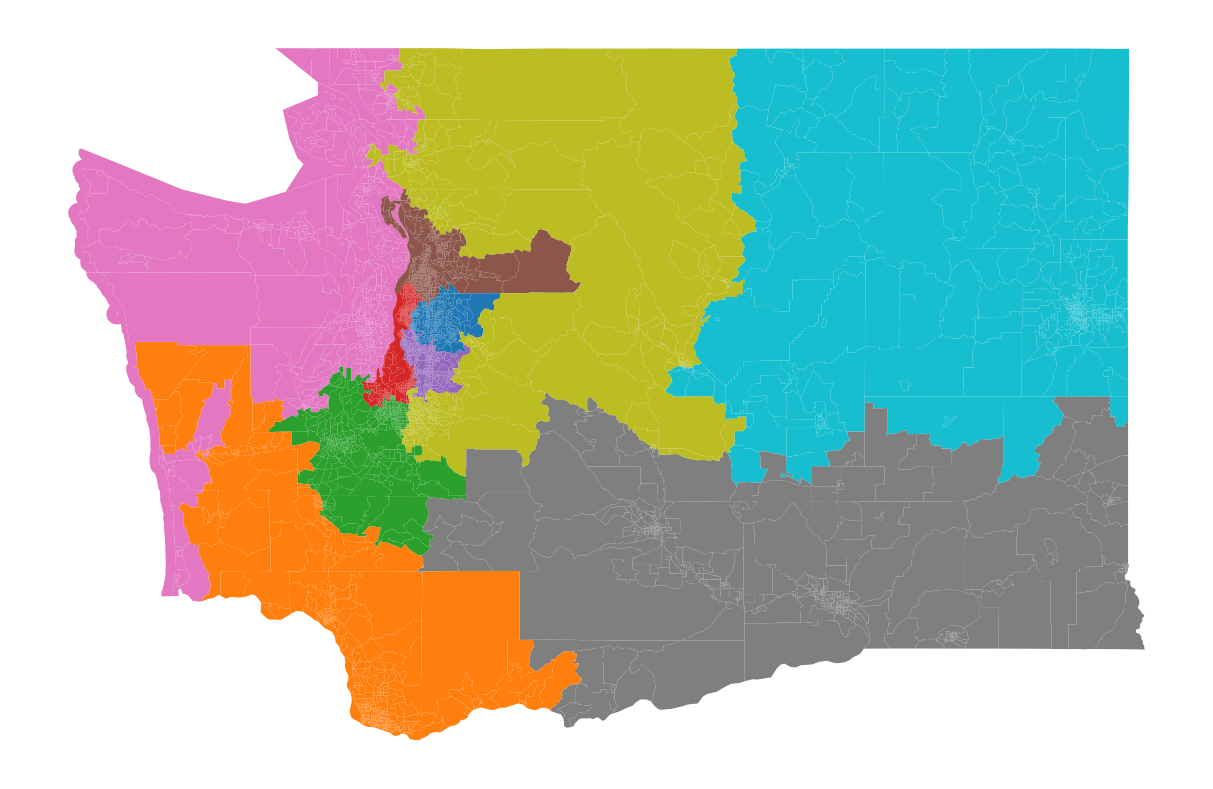

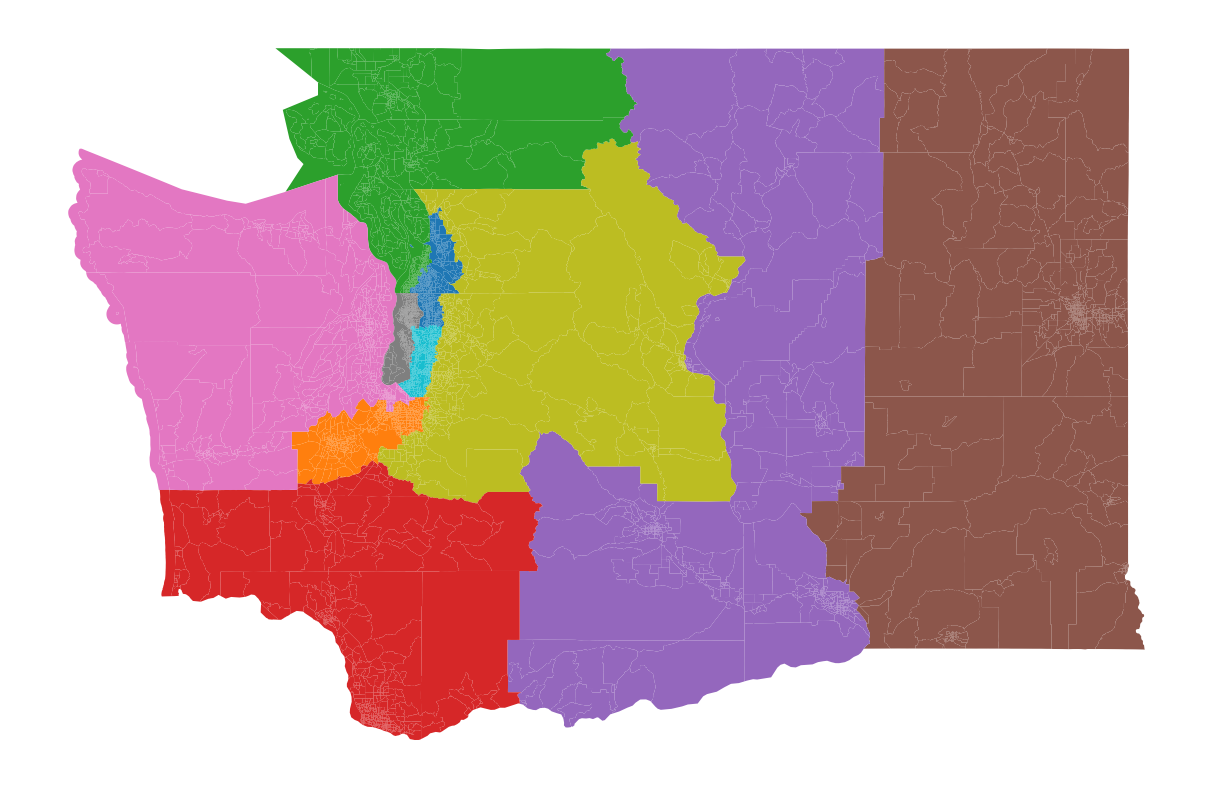

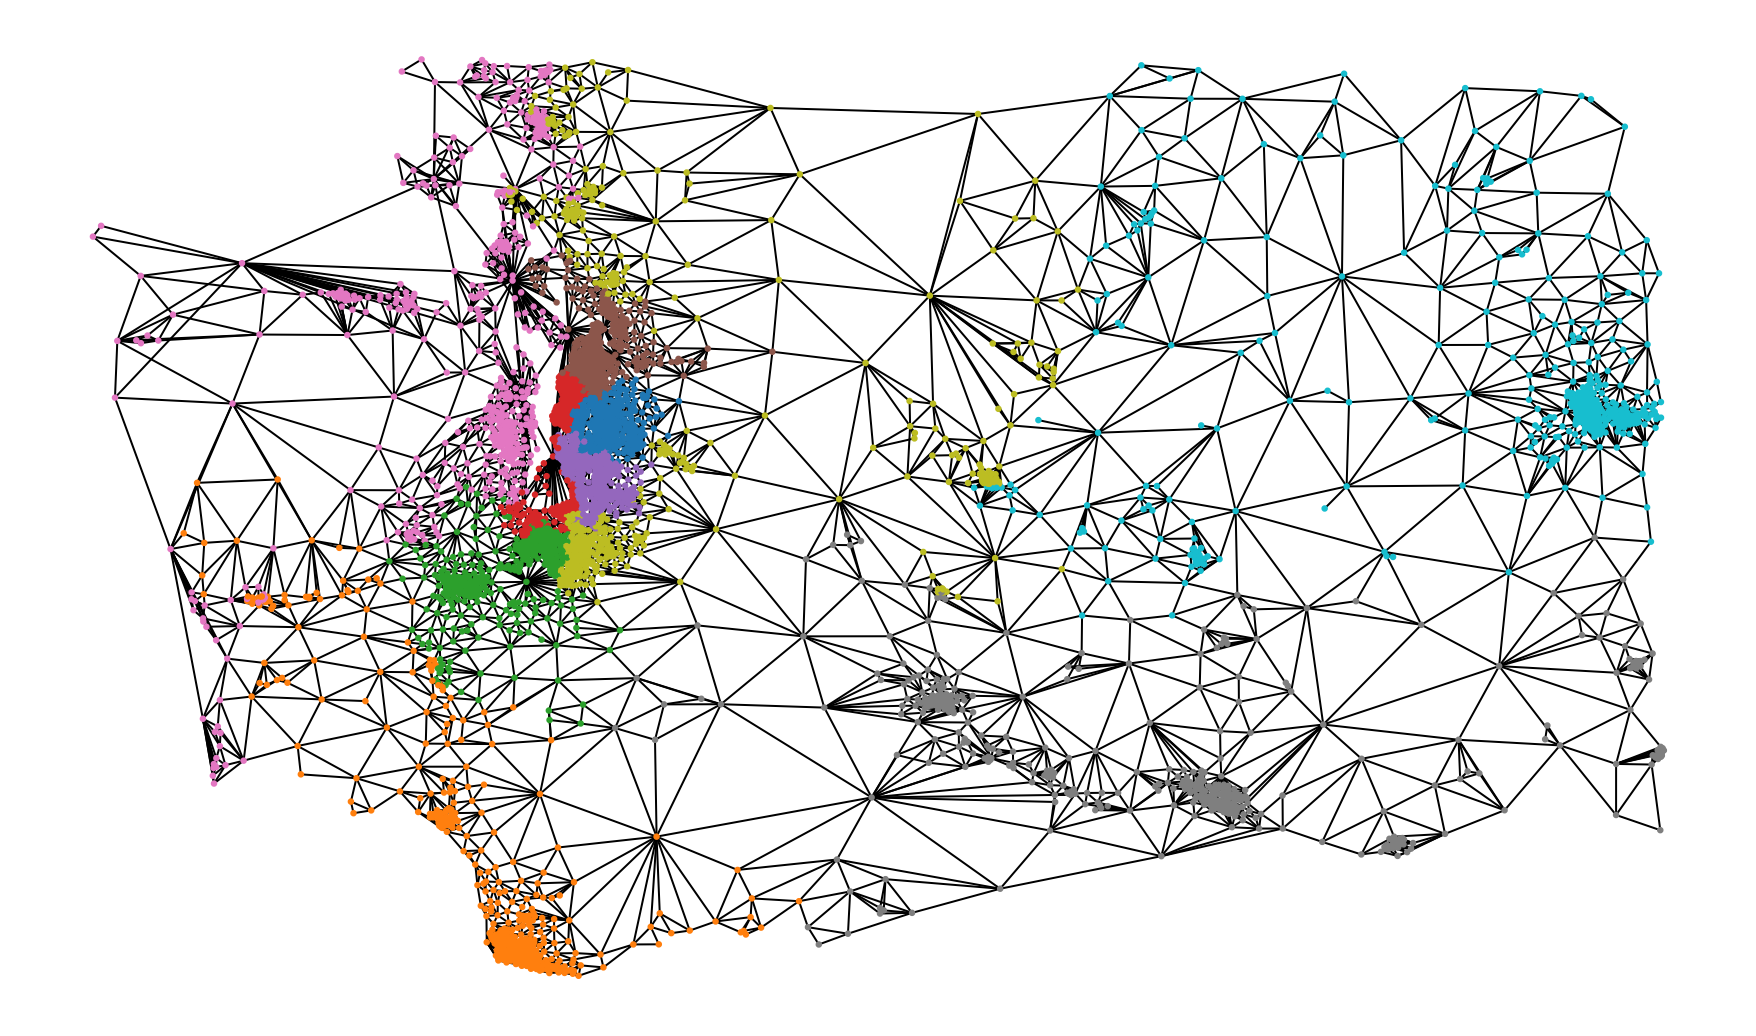

In [11]:

 
nx.draw(dual_graph, pos ={x:(dual_graph.nodes[x]["C_x"],dual_graph.nodes[x]["C_y"]) for x in dual_graph.nodes()}, node_color = [ dual_graph.nodes[x]["WACON"]  for x in dual_graph.nodes()],cmap='tab10',node_size=5)

plot_df['current'] = plot_df.index.map(dict(initial_chain_part.assignment))
 

plot_df.plot(column='current',cmap='tab10')
plt.axis('off')

plot_df.plot(column='WACON',cmap='tab10')
plt.axis('off')


plt.figure()

nx.draw(dual_graph, pos ={x:(dual_graph.nodes[x]["C_x"],dual_graph.nodes[x]["C_y"]) for x in dual_graph.nodes()}, node_color = [ cddict_trimmed[x]  for x in dual_graph.nodes()],cmap='tab10',node_size=5)


In [12]:
def compare_pop_accept(part):
    
    ideal_pop = sum(part['compare_pop'].values())/10
    
    devs = sum([(x-ideal_pop)**2 for x in part['compare_pop'].values()])
    
    pdevs = sum([(x-ideal_pop)**2 for x in part.parent['compare_pop'].values()])
    
    if pdevs > devs:
        if random.random() <.2:
            return True
        else:
            return False
    
    else: 
        return True

def compare_pop_strict_max(part):
    
    
    devs = max([x for x in part['compare_pop'].values()])
    
    pdevs = max([x for x in part.parent['compare_pop'].values()])
    
    if devs < pdevs:
        return True
    
    else: 
        return False
    
def compare_pop_strict_min(part):
    
    
    devs = min([x for x in part['compare_pop'].values()])
    
    pdevs = min([x for x in part.parent['compare_pop'].values()])
    
    if pdevs < devs:
        return True
    
    else: 
        return False

def pop_strict_max(part):
    
    
    pop_devs = max([x for x in part['population'].values()])
    
    pop_pdevs= max([x for x in part.parent['population'].values()])
    
    if pop_devs < pop_pdevs: 
        return True
    
    else: 
        return False
    
def pop_strict_min(part):
    
    
    devs = min([x for x in part['population'].values()])
    
    pdevs = min([x for x in part.parent['population'].values()])
    
    if pdevs < devs:
        return True
    
    else: 
        return False
    
def both_strict_max(part):
    
    
    compare_pop_devs = max([x for x in part['compare_pop'].values()])
    
    compare_pop_pdevs = max([x for x in part.parent['compare_pop'].values()])

    pop_devs = max([x for x in part['population'].values()])
    
    pop_pdevs = max([x for x in part.parent['population'].values()])

    if compare_pop_devs <= compare_pop_pdevs and pop_devs <= pop_pdevs:
        return True
    
    else: 
        return False
    
def compare_pop_both_strict_min(part):
    
    
    compare_pop_dev_min= min([x for x in part['compare_pop'].values()])
    
    compare_pop_pdev_min = min([x for x in part.parent['compare_pop'].values()])

    pop_dev_min = min([x for x in part['population'].values()])
    
    pop_pdev_min = min([x for x in part.parent['population'].values()])

    if compare_pop_dev_min >= compare_pop_pdev_min and pop_dev_min >= pop_pdev_min: 
        return True
    
    else: 
        return False

In [13]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), len(initial_enacted_part["cut_edges"])
)

tree_proposal = partial(recom, pop_col="P0010001", pop_target=ideal_pop, epsilon=0.02, node_repeats=1) #was .025





In [14]:
def population_deviation(part,num_districts):
    population_ideal = sum(part['population'].values())/num_districts
    compare_ideal = sum(part['compare_pop'].values())/num_districts
   
    population_deviation = (max(part['population'].values())-population_ideal)/population_ideal + (population_ideal-min(part['population'].values()))/population_ideal
    compare_deviation = (max(part['compare_pop'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(part['compare_pop'].values()))/compare_ideal

    return population_deviation + compare_deviation

population_ideal = sum(initial_chain_part['population'].values())/num_districts
compare_ideal = sum(initial_chain_part['compare_pop'].values())/num_districts



New Chain
recom  trial:  0 t 0
576109
635795
0.09906901418479858
0.03077240142183004
finalflip trial:  0 t 0
576109
626062
0.08291382343553336
0.033822257747640874
finalflip trial:  0 t 1000
576109
610409
0.056932399332148095
0.03800769887561531
finalflip trial:  0 t 2000
576109
610335
0.056809571415221596
0.03724069245495395
finalflip trial:  0 t 3000
576109
609003
0.05459866891054459
0.03682928630377011
finalflip trial:  0 t 4000
576109
608072
0.053053360928672
0.03771179792145153
finalflip trial:  0 t 5000
576109
607766
0.05254545089381377
0.03771179792145153
finalflip trial:  0 t 6000
576109
607766
0.05254545089381377
0.03771179792145153
finalflip trial:  0 t 7000
576109
607561
0.052205184367193055
0.03771179792145153
finalflip trial:  0 t 8000
576109
607561
0.052205184367193055
0.03771179792145153
finalflip trial:  0 t 9000
576109
607544
0.05217696714303427
0.03771179792145153
finalflip trial:  0 t 10000
576109
607115
0.05146489719220361
0.035648278109519954
finalflip trial:  0 t

finalflip trial:  0 t 100000
576828
605476
0.04755100221770783
0.0370005973824965


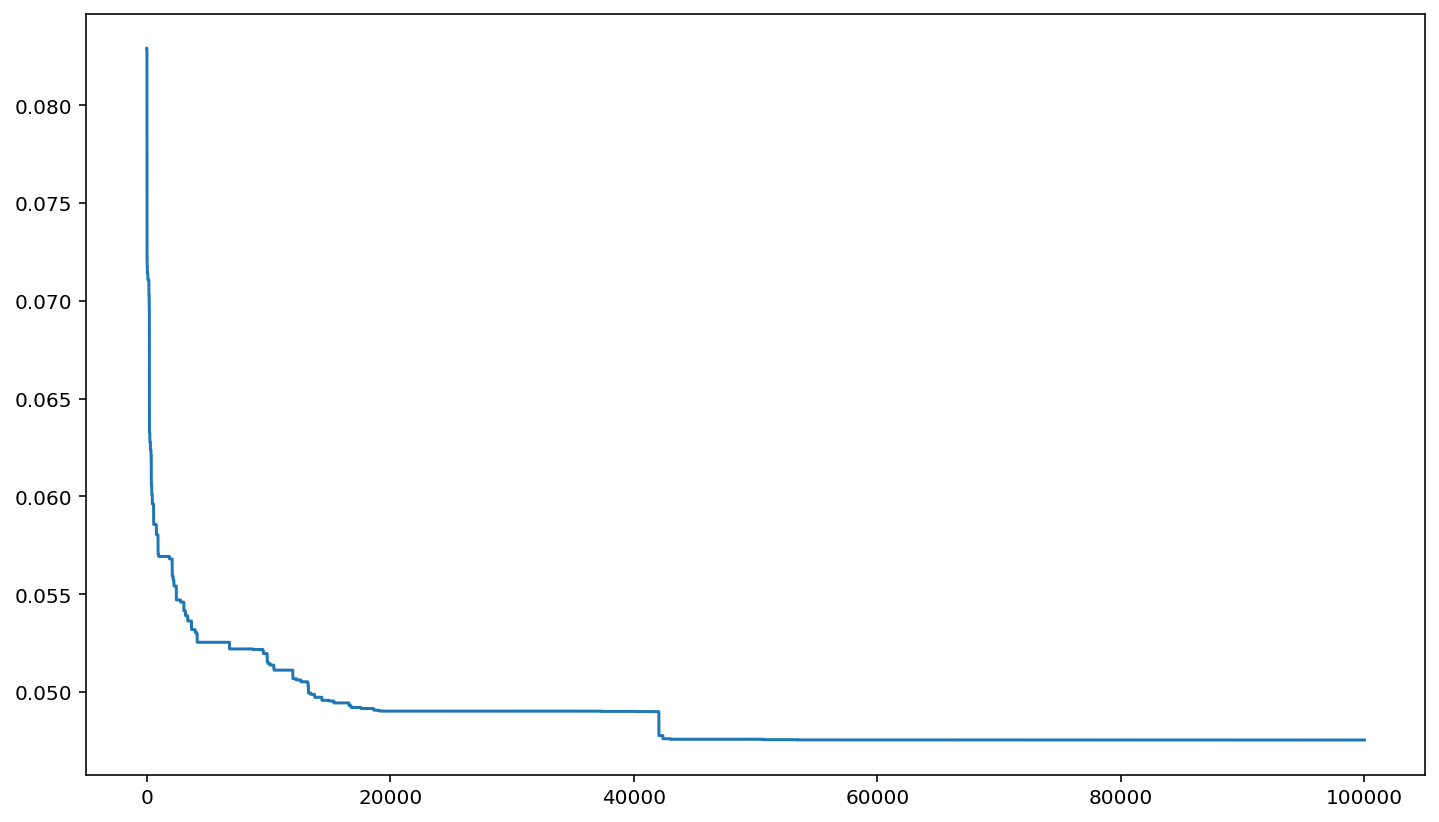

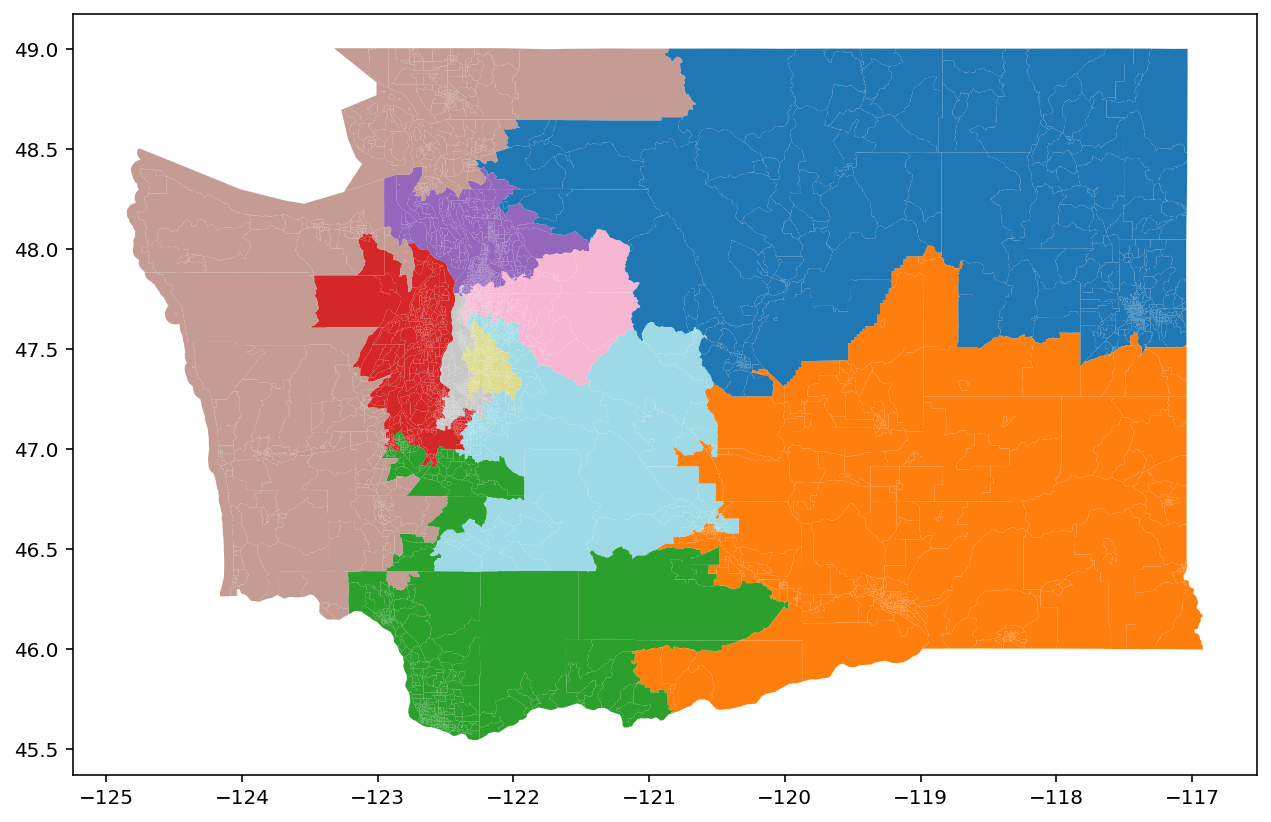

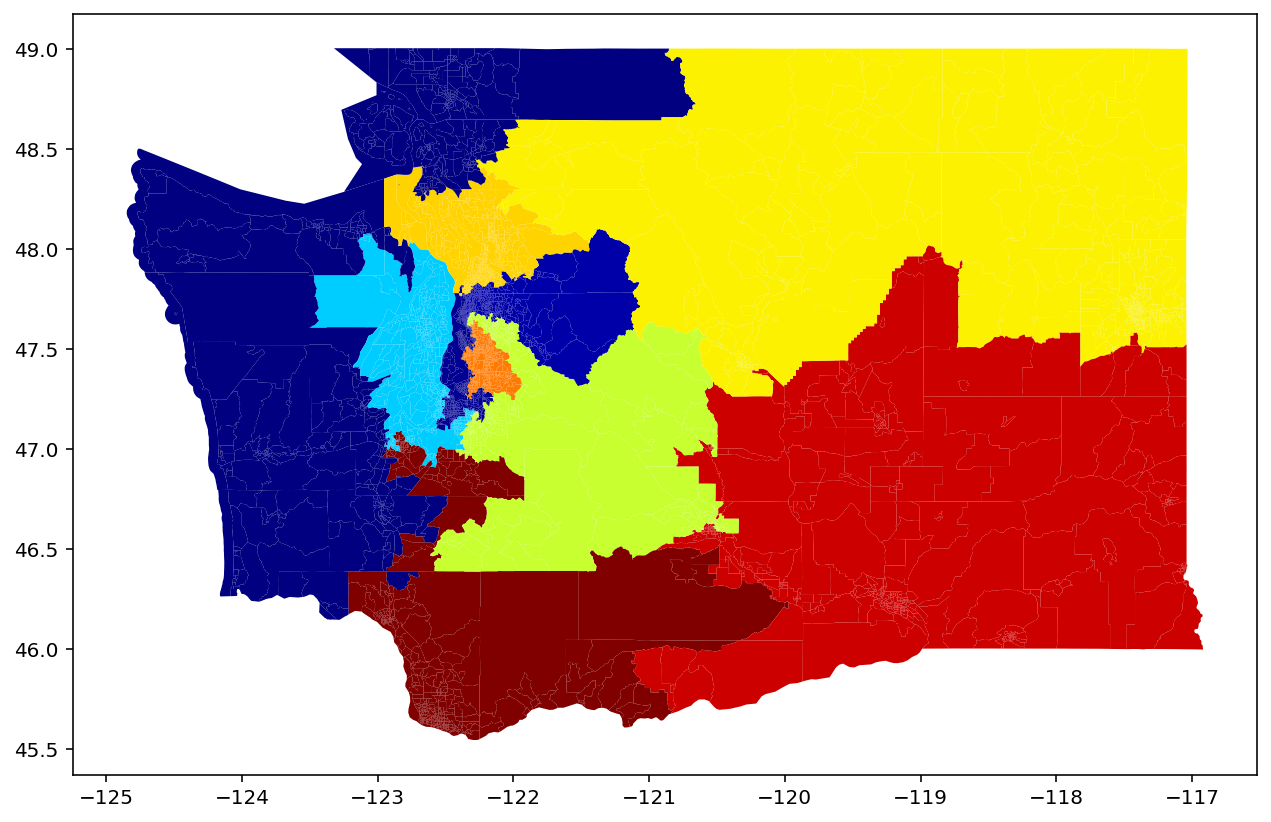

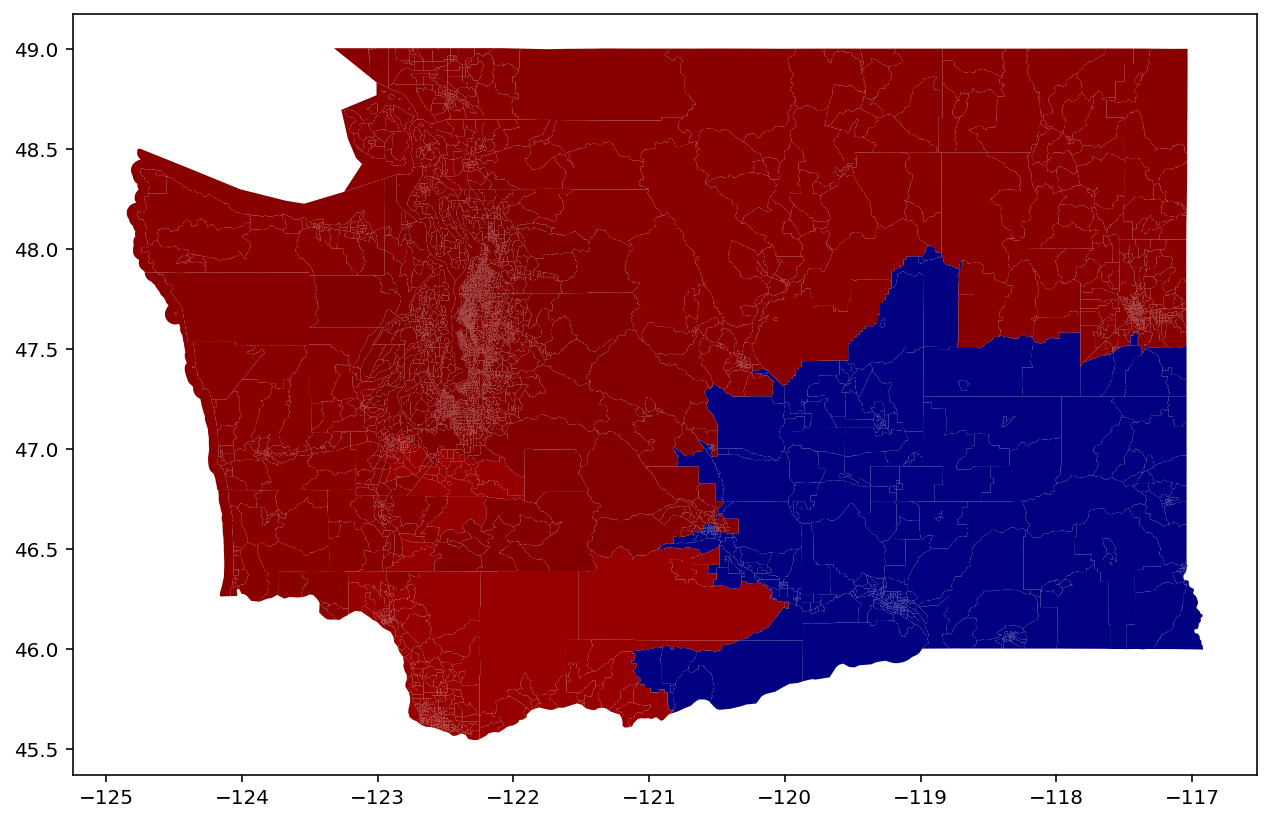


New Chain
recom  trial:  1 t 0
550593
637600
0.14441741308140552
0.036637210245804144
finalflip trial:  1 t 0
550593
624813
0.12319308100384932
0.036637210245804144
finalflip trial:  1 t 1000
563676
610271
0.0773400917458146
0.03212472069480659
finalflip trial:  1 t 2000
572627
606937
0.05694899769930033
0.03580531326501915
finalflip trial:  1 t 3000
572627
606710
0.05657221476494471
0.03716022816040064
finalflip trial:  1 t 4000
573265
606611
0.05534891510582538
0.038673476022483805
finalflip trial:  1 t 5000
575034
606277
0.051858278493711454
0.03540299179225262
finalflip trial:  1 t 6000
575034
606277
0.051858278493711454
0.03540299179225262
finalflip trial:  1 t 7000
575034
606256
0.05182342192269177
0.03540299179225262
finalflip trial:  1 t 8000
575072
606215
0.05169229482218916
0.034951353493792116
finalflip trial:  1 t 9000
575832
606196
0.05039928202103046
0.03719916249647482
finalflip trial:  1 t 10000
575832
606195
0.05039762218431523
0.03396631479111534
finalflip trial:  1 

In [15]:
newdir = "./MBR_Optimize_P0030001_100kSteps/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")
    

compare_vals = []    


for trial in range(5):
    
    print("")
    print("New Chain")
    
    
    good_seed = False
    while good_seed == False:
        cddict_trimmed =  recursive_tree_part(dual_graph,range(10),population_ideal,"P0010001", .02,1)

        starting_partition = Partition(dual_graph,cddict_trimmed,updater)
        
        
        seed_test = constraints.within_percent_of_ideal_population(starting_partition, 0.02) # was .015
        
        good_seed = seed_test(starting_partition)
    
    

    
    recom_chain = MarkovChain(
    proposal=tree_proposal,#slow_reversible_propose,#propose_random_flip, #
    constraints=[constraints.within_percent_of_ideal_population(starting_partition, 0.02)],
    accept=compare_pop_strict_max or both_strict_max or both_strict_min, #projected_accept,#projected_strict_max,
    initial_state=starting_partition,
    total_steps=100
        )

    
    t = 0

    for part in recom_chain:
        if t%100==0:
            print("recom ","trial: ",trial, "t", t )
            print(min([x for x in part['compare_pop'].values()]))
            print(max([x for x in part['compare_pop'].values()]))
            print((max(part['compare_pop'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(part['compare_pop'].values()))/compare_ideal)
            print((max(part['population'].values())-population_ideal)/population_ideal + (population_ideal-min(part['population'].values()))/population_ideal)
        t+=1
        
    flip_chain = MarkovChain(
proposal=tree_proposal,#propose_random_flip,#slow_reversible_propose,#
constraints=[constraints.within_percent_of_ideal_population(starting_partition, .02)],
#constraints.within_percent_of_ideal_population(starting_partition, max(.01,((max(part['population'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(part['population'].values()))/compare_ideal)/1.25))
accept=compare_pop_strict_max or compare_pop_strict_min or pop_strict_min or pop_strict_max, #projected_accept,#projected_strict_max,
initial_state=part,
total_steps=100001
    )

    t = 0
    for fpart in flip_chain:
        compare_vals.append((max(fpart['compare_pop'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(fpart['compare_pop'].values()))/compare_ideal)
        if t%1000==0:
            print("finalflip","trial: ",trial, "t", t )

            print(min([x for x in fpart['compare_pop'].values()]))
            print(max([x for x in fpart['compare_pop'].values()]))
            print((max(fpart['compare_pop'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(fpart['compare_pop'].values()))/compare_ideal)
            print((max(fpart['population'].values())-population_ideal)/population_ideal + (population_ideal-min(fpart['population'].values()))/population_ideal)
            
            with open(newdir+f"populations_{trial}_{t}.txt",'w') as f:
                f.write("Population\n")
                f.write(str(list(fpart['compare_pop'].values())) )
                f.write("\nComparison\n")
                f.write(str(list(fpart['population'].values()) ) )
                
                
            with open(newdir+f"MinPlusMax.txt_{trial}_{t}",'w') as f:
                f.write(str((max(fpart['compare_pop'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(fpart['compare_pop'].values()))/compare_ideal))
                f.write(str((max(fpart['population'].values())-compare_ideal)/compare_ideal + (compare_ideal-min(fpart['population'].values()))/compare_ideal))
                
        t+=1


    
    plt.plot(compare_vals)
    
    plot_df['optimized'] = plot_df.index.map(dict(fpart.assignment))
    
    plot_df['popvals'] = plot_df['optimized'].map(fpart['population'])
    plot_df['compare_popvals'] = plot_df['optimized'].map(fpart['compare_pop'])
    
    plot_df.plot(column='optimized',cmap='tab20')
    plot_df.plot(column='popvals',cmap='jet')
    plt.show()
    plot_df.plot(column='compare_popvals',cmap='jet')
    plt.show()
    



In [0]:
t